In [27]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [28]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [3]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = "FedEM_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 40

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 259.59it/s]


===> Initializing clients..


100%|███████████████████████████████████████████| 80/80 [00:43<00:00,  1.83it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.283% |Test Loss: 2.291 | Test Acc: 12.376% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [4]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [5]:
str_val = '4'

exp_names = ['weights/neurips/cifar10/alpha/'+str_val+'/FedAvg_adv/',
             'weights/neurips/cifar10/alpha/'+str_val+'/FedEM_adv/']

exp_modes = ['FedAvg', 'FedEM']

train_item = 'train_client_weights.npy'

In [6]:
num_victims = 40
num_exp = len(exp_names)
# Set Up Dictionaries -- list holds the adversary idx
exp_logs = {}

for j in range(num_exp):
    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None
        
        logs_adv += [adv_dict]
    
    exp_logs[j] = copy.deepcopy(logs_adv)


In [7]:
# Inter Boundary Distance Metric
custom_batch_size = 500


for j in range(num_exp):
    print('processing file', exp_names[j], '...')
    setting = exp_modes[j]
    
    if setting == 'FedAvg':

        args_.method = 'FedAvg'
        args_.n_learners= 3

        aggregator, clients = dummy_aggregator(args_, num_user=40)

        args_.save_path = exp_names[j]
        aggregator.load_state(args_.save_path)

        # This is where the models are stored -- one for each mixture --> learner.model for nn
        hypotheses = aggregator.global_learners_ensemble.learners

        # obtain the state dict for each of the weights 
        weights_h = []

        for h in hypotheses:
            weights_h += [h.model.state_dict()]

        weight_name = args_.save_path + train_item
        weights = np.load(weight_name)

        # Set model weights
        model_weights = []
        num_models = num_victims

        for i in range(num_models):
            model_weights += [weights[i]]

        # Generate the weights to test on as linear combinations of the model_weights
        models_test = []

        for (w0,w1,w2) in model_weights:
            # first make the model with empty weights
            new_model = copy.deepcopy(hypotheses[0].model)
            new_model.eval()
            new_weight_dict = copy.deepcopy(weights_h[0])
            for key in weights_h[0]:
                new_weight_dict[key] = w0*weights_h[0][key]  + w1*weights_h[1][key] +w2*weights_h[2][key] 
            new_model.load_state_dict(new_weight_dict)
            models_test += [new_model]
    

    elif setting == 'FedEM':

        args_.method = 'FedEM'
        args_.n_learners= 3

        aggregator, clients = dummy_aggregator(args_, num_user=40)

        args_.save_path = exp_names[j]

        aggregator.load_state(args_.save_path)

        # This is where the models are stored -- one for each mixture --> learner.model for nn
        hypotheses = aggregator.global_learners_ensemble.learners

        # obtain the state dict for each of the weights 
        weights_h = []

        for h in hypotheses:
            weights_h += [h.model.state_dict()]

        weight_name = args_.save_path + train_item
        weights = np.load(weight_name)

        # Set model weights
        model_weights = []
        num_models = num_victims

        for i in range(num_models):
            model_weights += [weights[i]]

        # Generate the weights to test on as linear combinations of the model_weights
        models_test = []

        for (w0,w1,w2) in model_weights:
            # first make the model with empty weights
            new_model = copy.deepcopy(hypotheses[0].model)
            new_model.eval()
            new_weight_dict = copy.deepcopy(weights_h[0])
            for key in weights_h[0]:
                new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
            new_model.load_state_dict(new_weight_dict)
            models_test += [new_model]    

    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        
        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test

processing file weights/neurips/cifar10/alpha/4/FedAvg_adv/ ...
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 358.85it/s]


===> Initializing clients..


100%|███████████████████████████████████████████| 80/80 [00:26<00:00,  3.03it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.283% |Test Loss: 2.291 | Test Acc: 12.376% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
processing file weights/neurips/cifar10/alpha/4/FedEM_adv/ ...
==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 358.38it/s]


===> Initializing clients..


100%|███████████████████████████████████████████| 80/80 [00:26<00:00,  3.03it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.283% |Test Loss: 2.291 | Test Acc: 12.376% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39


In [8]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(exp_names)):
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [9]:
print('FedAvg')

print('adv_target:', avg_nondiag(adv_target[0]))
print('adv_miss:', avg_nondiag(adv_miss[0]))
print('orig_acc:', np.mean(np.diagonal(orig_acc[0])))

print('FedEM')
print('adv_target:', avg_nondiag(adv_target[1]))
print('adv_miss:', avg_nondiag(adv_miss[1]))
print('orig_acc:', np.mean(np.diagonal(orig_acc[1])))

FedAvg
adv_target: 0.6123089909553527
adv_miss: 0.06908544534817337
orig_acc: 0.7225247219204902
FedEM
adv_target: 0.1867147811360132
adv_miss: 0.42812133371018063
orig_acc: 0.7376918777823448


Text(0.5, 1.0, 'CIFAR-10 Dataset Distribution Effect')

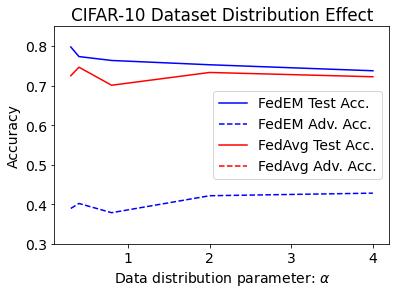

In [11]:
x = [0.3,0.4,0.8,2,4]

orig_acc_fedavg_adv = [0.7251609608530998, 0.7466991424560547, 0.7010599702596665, 0.7333782404661179, 0.7225247219204902]
adv_acc_fedavg_adv = [0.1200259300880134, 0.09458083282224834, 0.07339839516207576, 0.08315178174525499, 0.06908544534817337]

orig_acc_fedem_adv = [0.7978655159473419, 0.7735754914581776, 0.7637230187654496, 0.7528680577874184, 0.7376918777823448]
adv_acc_fedem_adv = [0.38947889905613964, 0.4020468255504966, 0.3786698496637818, 0.42157587496898113, 0.42812133371018063]

y2 = [orig_acc_fedavg_adv, adv_acc_fedavg_adv]
y1 = [orig_acc_fedem_adv, adv_acc_fedem_adv]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)


names1 = ['FedEM Test Acc.', 'FedEM Adv. Acc.']
names2 = ['FedAvg Test Acc.', 'FedAvg Adv. Acc.']
colors = ['b','r']
types = ['-', '--']


for i in range(len(names1)):
    plt.plot(x,y1[i],label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names1)):
    plt.plot(x,y2[i],label= names2[i], linestyle = types[i], color = colors[1])
#     plt.plot(x,y2[i], linestyle = types[i], color = colors[1])

plt.legend(frameon=True)
plt.xlim(0.1,4.2);
plt.ylim(0.3, 0.85);
plt.xlabel('Data distribution parameter: '+r'$\alpha$')
plt.ylabel('Accuracy')
plt.title("CIFAR-10 Dataset Distribution Effect")


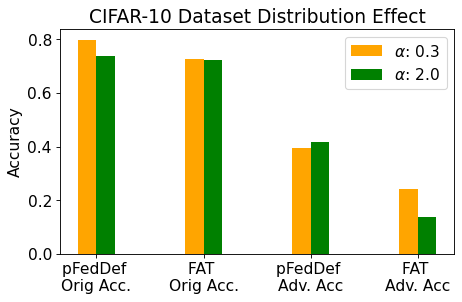

In [32]:

alpha_03 = [0.7978655159473419, 0.7251609608530998, 0.3947889905613964, 0.1200259300880134 * 2]
alpha_2 = [0.7376918777823448, 0.7225247219204902, 0.41812133371018063, 0.06908544534817337 * 2]

fedem_orig_acc = [0.7978655159473419, 0.7376918777823448]
fedadg_orig_acc = [0.7251609608530998, 0.7225247219204902]
fedem_adv_acc = [0.38947889905613964, 0.42812133371018063]
fedavg_adv_acc = [0.1200259300880134, 0.06908544534817337]

# Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14.5}

# Set Labels
labels = ['pFedDef \nOrig Acc.', 'FAT \nOrig Acc.', 'pFedDef \nAdv. Acc', 'FAT \nAdv. Acc']

# plt.figure()

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
rects1 = ax.bar(x = x - width/8, height =  alpha_03,
                capsize = 3, width = width/4, label=r'$\alpha$:'+ " 0.3", color='orange')
rects2 = ax.bar(x = x+width/8, height = alpha_2, 
                capsize = 3, width = width/4, label=r'$\alpha$:'+ " 2.0", color = 'green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('CIFAR-10 Dataset Distribution Effect')
ax.set_xticks(x)
# ax.set_xlabel('Plan Method')
ax.set_xticklabels(labels)
ax.legend()

# Set Y axis to zero
# plt.ylim(0,)

fig.tight_layout()

plt.show()

In [14]:
x

array([0, 1, 2, 3])